In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


from src.globals import processed_data_dir, saved_model_dir, vis_dir
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[]

In [5]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [6]:
from src.helpers import WindowGenerator, get_filenames_in_directory

In [7]:
train_files = get_filenames_in_directory(train_dir)

In [8]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) - 1 # number of columns without embedding column
n_features

11

In [9]:
# number of locations for embedding inputs
# 4
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

4

In [10]:
# Model configs
INPUT_WIDTH = 24
LABEL_WIDTH = 6
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [11]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')
w1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): ['Lufttemperatur [GradC]']

# Define model & metrics

In [12]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, 11))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([ embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)

output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)

output = output(lstm_layer)[:,-LABEL_WIDTH:,:]

model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

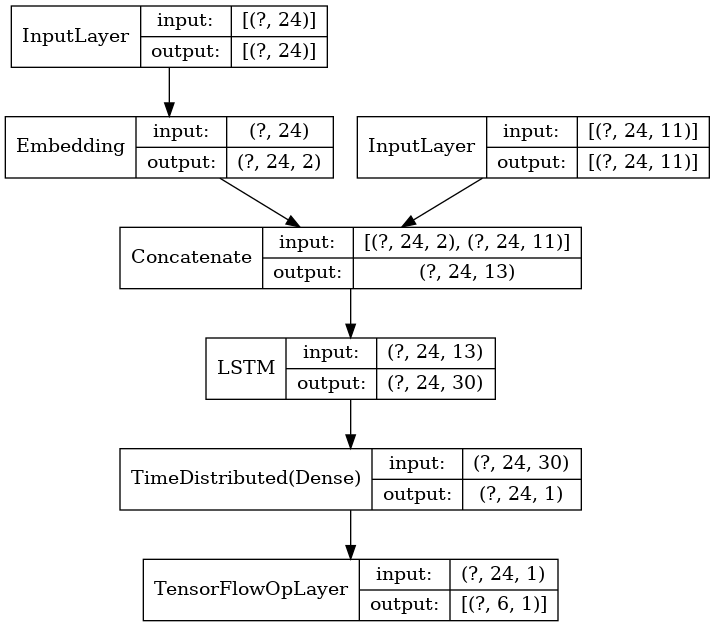

In [13]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'lstm.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96
)

# Train model

In [14]:
# Train configs
MAX_EPOCHS = 15

In [15]:
METRICS = [
      tf.keras.metrics.MeanSquaredError(name='MSE'),
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [16]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=5, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [17]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/15
2188/2188 [==============================] - 75s 34ms/step - loss: 0.2183 - MSE: 0.2183 - MAE: 0.3524 - val_loss: 0.1314 - val_MSE: 0.1314 - val_MAE: 0.2800
Epoch 2/15
2188/2188 [==============================] - 130s 60ms/step - loss: 0.0968 - MSE: 0.0968 - MAE: 0.2379 - val_loss: 0.1060 - val_MSE: 0.1060 - val_MAE: 0.2499
Epoch 3/15
2188/2188 [==============================] - 103s 47ms/step - loss: 0.0800 - MSE: 0.0800 - MAE: 0.2139 - val_loss: 0.0989 - val_MSE: 0.0989 - val_MAE: 0.2395
Epoch 4/15
2188/2188 [==============================] - 112s 51ms/step - loss: 0.0728 - MSE: 0.0728 - MAE: 0.2027 - val_loss: 0.0932 - val_MSE: 0.0932 - val_MAE: 0.2313
Epoch 5/15
2188/2188 [==============================] - 122s 56ms/step - loss: 0.0682 - MSE: 0.0682 - MAE: 0.1954 - val_loss: 0.0885 - val_MSE: 0.0885 - val_MAE: 0.2244
Epoch 6/15
2188/2188 [==============================] - 112s 51ms/step - loss: 0.0649 - MSE: 0.0649 - MAE: 0.1901 - val_loss: 0.0848 - val_MSE: 0.0848 - val

Text(0, 0.5, 'val_loss')

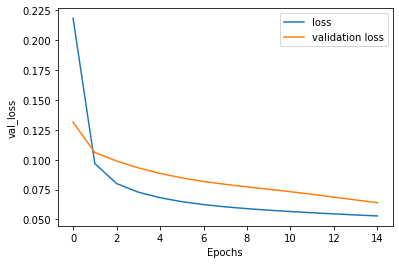

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [19]:
model.save(str(saved_model_dir/model_name))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[2021-08-01 19:46:37 | deprecation] From /home/heckert/anaconda3/envs/sbg-weather/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py:1813: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210801/assets


[2021-08-01 19:46:38 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210801/assets
